In [37]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open('data_clean/filesIDV.pickle', 'rb') as f:
    files_idv = pickle.load(f)

In [4]:
idv_logs = []
for file in files_idv:
    entry={'file': file}
    with open(file) as f:
        for line in f.readlines():
            if line.startswith('start'):
                x,y = line.split('=')
                entry['_'.join(x.split('.')[-2:])] = y.rstrip()
            if line.startswith('end'):
                x,y = line.split('=')
                entry['_'.join(x.split('.')[-2:])] = y.rstrip()
            if line.startswith('end.callData.cti.outbound.oid'):
                x,y = line.split('=')
                entry['id'] = y.rstrip()
            
        idv_logs.append(entry)

idv_logs_df = pd.DataFrame.from_dict(idv_logs).drop(['request_module'],axis=1)
idv_logs_df.dropna(subset=['end_duration'],inplace=True)
idv_logs_df['end_duration'] = idv_logs_df['end_duration'].apply(lambda x: float(x[:-1]))

#idv_logs_df.replace(r'^\s*$', 'none', regex=True,inplace=True)

# 4 fifferent types of 
outbound = [col for col in idv_logs_df.columns if col.startswith('outbound')]
pd.concat((idv_logs_df[outbound]['outbound_call_result'].value_counts(normalize = True), idv_logs_df[outbound]['outbound_call_result'].value_counts(normalize = False)),axis=1)

outbound_call_result  outbound_call_result
OK                      0.634268                 56042
Hangup                  0.245006                 21648
Error                   0.112985                  9983
Disconnect              0.007741                   684

In [5]:
files_idv_ok         = idv_logs_df.query('outbound_call_result == "OK"')['file'].tolist()
files_idv_hangup     = idv_logs_df.query('outbound_call_result == "Hangup"')['file'].tolist()
files_idv_error      = idv_logs_df.query('outbound_call_result == "Error"')['file'].tolist()
files_idv_disconnect = idv_logs_df.query('outbound_call_result == "Disconnect"')['file'].tolist()

In [6]:
with open('data_clean/filesIDV_ok.pickle', 'wb') as f:
    pickle.dump(files_idv_ok,f)

with open('data_clean/filesIDV_hangup.pickle', 'wb') as f:
    pickle.dump(files_idv_hangup,f)
    
with open('data_clean/filesIDV_error.pickle', 'wb') as f:
    pickle.dump(files_idv_error,f)
    
with open('data_clean/filesIDV_disconnect.pickle', 'wb') as f:
    pickle.dump(files_idv_disconnect,f)

# Persistance

In [8]:
# get # of prompts
counts = {}
for k in range(1,17):
    count=0
    for file in files_idv_ok:
        with open(file) as f:
            for line in f.readlines():
                if line.startswith(f'rec[{k}]'):
                    count += 1
                    #files_hungup_open_menu.append(file)
                    break
    counts[k] = count
    print(k,count)

1 56042
2 56042
3 51837
4 33259
5 17667
6 9641
7 5243
8 2540
9 1060
10 408
11 164
12 50
13 12
14 5
15 1
16 0


In [9]:
persistence_all = {}
for k in range(1,16):
    print(k)
    entries = []
    for file in files_idv:
        entry = {}
        flag = False
        with open(file) as f:
            for line in f.readlines():
                if line.startswith('start.time'):
                    start_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')

                if line.startswith(f'rec[{k}]'):
                    flag = True  

                if line.startswith(f'rec[{k+1}]'):
                    flag = False

                if line.startswith('end.time'):
                    end_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')
        if flag:
            entry['file'] = file
            entry['Duration'] = (end_time - start_time).total_seconds()
            entries.append(entry)
    persistence_all[k] = entries

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [10]:
persistence_ok = {}
for k in range(1,16):
    print(k)
    entries = []
    for file in files_idv_ok:
        entry = {}
        flag = False
        with open(file) as f:
            for line in f.readlines():
                if line.startswith('start.time'):
                    start_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')

                if line.startswith(f'rec[{k}]'):
                    flag = True  

                if line.startswith(f'rec[{k+1}]'):
                    flag = False

                if line.startswith('end.time'):
                    end_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')
        if flag:
            entry['file'] = file
            entry['Duration'] = (end_time - start_time).total_seconds()
            entries.append(entry)
    persistence_ok[k] = entries

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [11]:
persistence_numbers_ok  = [len(e) for e in persistence_ok.values()]
persistence_numbers_all = [len(e) for e in persistence_all.values()]

In [12]:
durs_avg=[]
count_avg=[]
for k in range(2,16):
    print(k,end=' ')
    per_ =  persistence_ok[k]
    files_ = [f['file'] for f in per_]

    durs = []; counts=[]
    for file in files_:
        dur = 0; count = 0
        with open(file) as f:
            gen = iter(f.readlines())
            for line in gen:
                if 'state=OpenMenu' in line:
                    while True:
                        next_line = gen.__next__()
                        if 'duration' in next_line:
                            count += 1
                            dur += float(next_line.split('=')[1].rstrip()[:-1])
                            break
            durs.append(dur)
            counts.append(count)
    durs_avg.append(np.mean(durs))
    count_avg.append(np.mean(counts))
durs_avg = [0] + durs_avg
count_avg = [0] + count_avg

2 3 4 5 6 7 8 9 10 11 12 13 14 15 

In [13]:
py.init_notebook_mode(connected=True)

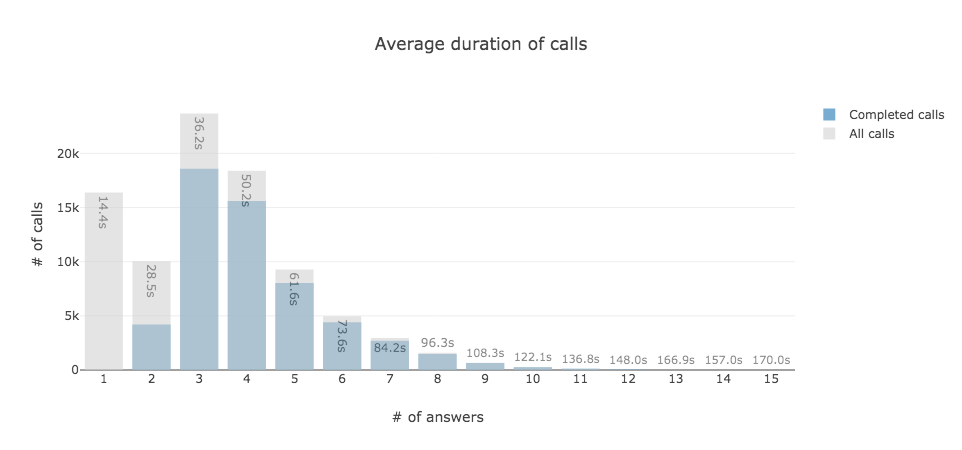

In [15]:
text2 = [str(round(np.array([t['Duration'] for t in e]).mean(),1))+'s' for e in persistence_all.values()]

trace1 = go.Bar(
            x=[str(k) for k in list(range(1,16))],
            y=persistence_numbers_ok,
            opacity=0.6,
            name = 'Completed calls'
            
    )

trace2 = go.Bar(
            x=[str(k) for k in list(range(1,16))],
            y=persistence_numbers_all,
            text = text2,
            textposition = 'auto',
            opacity=0.6, 
            marker=dict(color='rgba(211,211,211,1)'),
            name='All calls'
            
    )

data1 = [trace1, trace2]
layout = go.Layout(xaxis=dict(title='# of answers',type='category',showticklabels=True), yaxis=dict(title='# of calls') ,
                   title=dict(text='Average duration of calls'), barmode='overlay')

fig1 = go.Figure(data=data1, layout=layout)
pio.show(fig1)

In [ ]:
pio.write_image(fig1,'images/IDV_BARCHART.pdf', width=1000, height=600)

# Day of the week

In [ ]:
start_dates=[]
for file in files_idv:
    with open(file) as f:
        for line in f.readlines():
            if line.startswith('start.time'):
                    start_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')
                    start_dates.append(start_time)
                    break

day_the_week = [date.weekday() for date in start_dates]

pd.DataFrame.from_dict(dict(Counter(day_the_week)),orient='index',columns=['Freq']).to_csv('data_clean/dat_of_week_idv.csv')

# Customer Paths

In [31]:
paths = get_paths(files_idv)
paths_ALL = [p for p in [p['path'].split('_') for p in paths]]

paths = get_paths(files_idv_ok)
paths_OK = [p for p in [p['path'].split('_') for p in paths]]

paths = get_paths(files_idv_disconnect)
paths_DISCONNECT = [p for p in [p['path'].split('_') for p in paths]]

paths = get_paths(files_idv_error)
paths_ERROR = [p for p in [p['path'].split('_') for p in paths]]

paths = get_paths(files_idv_hangup)
paths_HANGUP = [p for p in [p['path'].split('_') for p in paths]]

In [32]:
paths_FAIL = paths_HANGUP + paths_DISCONNECT + paths_ERROR
len(paths_FAIL)/len(paths_ALL)

0.36554189337465925

In [34]:
x=Counter(["_".join(p) for p in paths_OK])
pprint(x.most_common(5))
path_ = x.most_common()[0][0] 
pprint(path_)
print(survival_prob(path_,paths_FAIL, paths_ALL))

[('GetAccessNumber_VerifyPin_OpenMenu', 11971),
 ('GetAccessNumber_VerifyPin_OpenMenu_CallSteering', 5333),
 ('GetAccessNumber_OpenMenu_CallSteering', 4326),
 ('GetAccessNumber_OpenMenu', 4200),
 ('GetAccessNumber_VerifyPin_OpenMenu_OpenMenu', 2675)]
'GetAccessNumber_VerifyPin_OpenMenu'
0.747804187677114


# Onion

In [45]:
paths_all = get_paths_all(files_idv)

paths_all=[p for p in [p['path'].split(',') for p in paths_all]]

edges_all=it.chain.from_iterable([list(zip(p,p[1:])) for p in paths_all if len(p)>1])

g=nx.DiGraph()
g.add_edges_from(edges_all)
p=nx.drawing.nx_pydot.to_pydot(g)
p.write('images/graph_ALL.dot')

# Errors

In [46]:
with open('data_clean/filesIDV_error.pickle', 'rb') as f:
    files_idv_error = pickle.load(f)

In [47]:
idv_error_logs = []
for file in files_idv_error:
    entry={'file': file}
    with open(file) as f:
        for line in f.readlines():

            if "state=" in line:
                entry['state']=(line.split('=')[1]).rstrip()
            if line.startswith('end'):
                x,y = line.split('=')
                entry['_'.join(x.split('.')[-2:])] = y.rstrip()
            
        idv_error_logs.append(entry)

idv_error_logs_df = pd.DataFrame.from_dict(idv_error_logs)#.drop(['request_module'],axis=1)
idv_error_logs_df.dropna(subset=['end_duration'],inplace=True)
idv_error_logs_df['end_duration'] = idv_error_logs_df['end_duration'].apply(lambda x: float(x[:-1]))


In [48]:
error_df_per=idv_error_logs_df[['end_reason','state']].groupby('end_reason')['state'].value_counts(normalize=True).apply(lambda x: str(int(100*round(x,2)))+'%')
error_df_per.index.names = ['Error type','State']
error_df_per_g = pd.concat([error_df_per.loc['HOST_ERROR',:], error_df_per.loc['VXML_ERROR',:],error_df_per.loc['ERROR',:]])
error_df_per_g.name =''

error_df_raw=idv_error_logs_df[['end_reason','state']].groupby('end_reason')['state'].value_counts()
error_df_raw.index.names = ['Error type','State']
error_df_raw_g = pd.concat([error_df_raw.loc['HOST_ERROR',:], error_df_raw.loc['VXML_ERROR',:],error_df_raw.loc['ERROR',:]])
error_df_raw_g.name =''

error_df_g=pd.concat([error_df_raw_g,error_df_per_g],axis=1)

In [49]:
error_df_raw_g

Error type  State              
HOST_ERROR  GetAccessNumber        9113
            ConfirmAccessNumber     158
            VerifyPin                53
VXML_ERROR  OpenMenu                606
            SLM_GetCallReason        19
            GetAccessNumber          13
            VerifyPin                 5
            VerifyMiddleName          3
            SLM_GetBranchReason       2
            ConfirmAccessNumber       1
            VerifyDateOfBirth         1
            VerifyMobileNumber        1
            VerifyStreetName          1
ERROR       GetAccessNumber           5
            OpenMenu                  2
Name: , dtype: int64

# Steering

In [55]:
paths=[]
for file in files_idv:
    entry = {'file':file}
    path = ''
    lines = open(file).readlines()
    for line in lines:
        if "state=" in line:
            state = line.split('=')[1].rstrip()
            if "_" in state:
                path+= ',' +  state
    entry['path'] = path[1:]
    paths.append(entry)

paths_steering = [entry for entry in paths if len(entry['path'])]
pprint(Counter([len(p['path'].split(',')) for p in paths_steering]))

Counter({1: 18207, 2: 1978, 3: 73})


In [56]:
paths=[]
for file in files_idv_hangup:
    entry = {'file':file}
    path = ''
    lines = open(file).readlines()
    for line in lines:
        if "state=" in line:
            state = line.split('=')[1].rstrip()
            if "_" in state:
                path+= ',' +  state
    entry['path'] = path[1:]
    paths.append(entry)

paths_steering_hangup = [entry for entry in paths if len(entry['path'])]
pprint(Counter([len(p['path'].split(',')) for p in paths_steering_hangup]))

Counter({1: 355, 2: 45, 3: 1})
